# 01_PL_06b_Project_network_Voronois (Uses function voronoi_points_within_aoi())

This notebook __loads pop data__ (Looking for population and density) and __distributes it to Voronoi polygons created from nodes__ of the project network from 01_PL_04.

__Inputs:__
* Area of interest (City, Guadalajara)
* Blocks with population data
* Nodes from the project network, which was generated using the networks join procedure (Notebook 01_PL_04_Combine_networks)
  
__Outputs:__
* Voronoi polygons for the project_network
* Nodes with pop data (Population and density)

## Import libraries

In [1]:
first_folder_path = "../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src
else:
    import src

## Notebook config

In [3]:
# ----- ----- ----- City of analysis ----- ----- -----
city = 'guadalajara'

# ----- ----- ----- Input data directories ----- ----- ----- 
# Nodes and edges from notebook 01_PL_04_Combine_networks
nodes_dir = first_folder_path + f"data/output/shape/network_project/{city}/part02_step06_ntwsconsolidate/{city}_nodes_proj_net_consolidated5m.gpkg"
edges_dir = first_folder_path + f"data/output/shape/network_project/{city}/part02_step06_ntwsconsolidate/{city}_edges_proj_net_consolidated5m.gpkg"

# Blocks with population data
blocks_dir = first_folder_path + f"data/input/shape/Manzanas_Pop_Guadalajara/pobcenso_inegi_20_mzaageb_mza_gdl.gpkg"
# Blocks unique ID column (Will become index)
blocks_unique_id = 'cvegeo_mza'
# Column where population data is located within each block
pop_col = 'pobtot'

# ----- ----- ----- Projection to be used when needed ----- ----- ----- 
projected_crs = "EPSG:32613" #Guadalajara = 'EPSG:32613'

# ----- ----- ----- Output ----- ----- ----- 
output_dir = first_folder_path + f"data/output/shape/network_project_voronoi/"
local_save = False

## Load data

### __Load data__ - Pop data in blocks

In [4]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load blocks
blocks_gdf = gpd.read_file(blocks_dir)
# Set crs
if blocks_gdf.crs != projected_crs:
    blocks_gdf = blocks_gdf.to_crs(projected_crs)
# Set index if necessary
if blocks_unique_id in blocks_gdf.columns:
    blocks_gdf.set_index(blocks_unique_id,inplace=True)
# Filter for data of interest
blocks_gdf = blocks_gdf[[pop_col,'geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")


# Show
print(blocks_gdf.crs)
print(blocks_gdf.info())
blocks_gdf.head(2)

TIME: 6.8883912563323975 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 54804 entries, 1412000620299011 to 1412000017065020
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pobtot    54804 non-null  int64   
 1   geometry  54804 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.3+ MB
None


,pobtot,geometry
cvegeo_mza,,
1412000620299011,16,"POLYGON ((659974.886 2297605.164, 659923.165 2..."
1412000620299032,18,"POLYGON ((659879.976 2297823.117, 659923.355 2..."


## Create area of interest

In [5]:
print(f"--- Creating a defined area of interest that cuts the voronois.")

# Turn all blocks into a single buffered geometry
blocks_buffer = blocks_gdf.copy()
blocks_buffer = blocks_buffer.buffer(100).reset_index().dissolve()
# Rename geom col
blocks_buffer.rename(columns={0:'geometry'},inplace=True)
# Turn into GeoDataFrame
blocks_buffer = blocks_buffer.set_geometry('geometry')
blocks_buffer = blocks_buffer.set_crs(projected_crs)
blocks_buffer.drop(columns=[blocks_unique_id],inplace=True)

# Show
print(blocks_buffer.info)
blocks_buffer

--- Creating a defined area of interest that cuts the voronois.
<bound method DataFrame.info of                                             geometry
0  MULTIPOLYGON (((653794.234 2261597.14, 653787....>


,geometry
0,"MULTIPOLYGON (((653794.234 2261597.14, 653787...."


<Axes: >

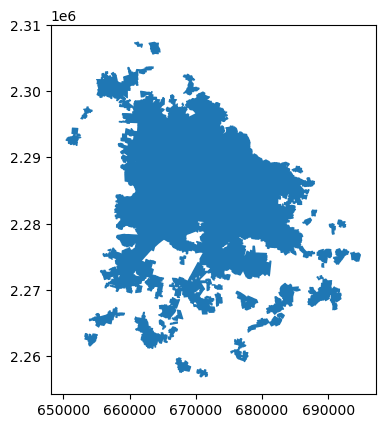

In [6]:
blocks_buffer.plot()

### __Load data__ - Network

In [7]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load nodes
cons_nodes = gpd.read_file(nodes_dir)
# Set crs
if cons_nodes.crs != projected_crs:
    cons_nodes = cons_nodes.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Filter for data of interest
cons_nodes = cons_nodes[['osmid','x','y','geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(cons_nodes.crs)
print(cons_nodes.info())
cons_nodes.head(2)

TIME: 0.6476545333862305 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125089 entries, 0 to 125088
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     125089 non-null  object  
 1   x         125089 non-null  float64 
 2   y         125089 non-null  float64 
 3   geometry  125089 non-null  geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 3.8+ MB
None


,osmid,x,y,geometry
0,67637870229114485,676378.709485,2.291145e+06,POINT (676378.709 2291144.858)
1,67640019229114922,676400.196372,2.291149e+06,POINT (676400.196 2291149.223)


## Create voronoi polygons using nodes

In [8]:
print(f"--- Creating voronois with nodes osmid data.")

#Time start
time_1 = time.time()
#Process
voronois_gdf = src.voronoi_points_within_aoi(area_of_interest=blocks_buffer,
                                             points=cons_nodes,
                                             points_id_col='osmid',
                                             projected_crs=projected_crs)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_gdf.crs)
print(voronois_gdf.info())
voronois_gdf.head(2)

--- Creating voronois with nodes osmid data.
Error = 0.0%. Admissible.
TIME: 279.08228039741516 seconds.
EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116303 entries, 0 to 116302
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     116303 non-null  object  
 1   geometry  116303 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 1.8+ MB
None


,osmid,geometry
0,65394725226151578,"POLYGON ((-103.52396 20.44653, -103.52287 20.4..."
1,67016094225777232,"POLYGON ((-103.36859 20.4107, -103.36869 20.41..."


In [9]:
voronois_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Assign blocks population data to voronois

In [11]:
# Prepare voronois_gdf for function src.assing_blocks_attribute_to_voronoi()
voronois_gdf_prep = voronois_gdf.copy()

# Set crs
if voronois_gdf_prep.crs != projected_crs:
    voronois_gdf_prep = voronois_gdf_prep.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Set index if necessary
if 'osmid' in voronois_gdf_prep.columns:
    original_len = len(voronois_gdf_prep)
    voronois_gdf_prep = voronois_gdf_prep.drop_duplicates(subset=['osmid'])
    new_len = len(voronois_gdf_prep)
    voronois_gdf_prep.set_index('osmid',inplace=True)
    print(f"Dropped {new_len-original_len} nodes to set osmid as nodes index.")

# Show
print(voronois_gdf_prep.shape)
voronois_gdf_prep.head(2)

Changed crs to EPSG:32613.
Dropped 0 nodes to set osmid as nodes index.
(116303, 1)


,geometry
osmid,
65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22..."
67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2..."


In [12]:
# Prepare voronois_gdf for function src.assing_blocks_attribute_to_voronoi()

# Show
print(blocks_gdf.shape)
blocks_gdf.head(2)

(54804, 2)


,pobtot,geometry
cvegeo_mza,,
1412000620299011,16,"POLYGON ((659974.886 2297605.164, 659923.165 2..."
1412000620299032,18,"POLYGON ((659879.976 2297823.117, 659923.355 2..."


In [13]:
print(f"--- Assigning pop col {pop_col} from blocks to voronois .")

#Time start
time_1 = time.time()
#Process
voronois_pop_gdf = src.assing_blocks_attribute_to_voronoi(blocks_gdf, voronois_gdf_prep, attribute_column=pop_col)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Assigning pop col pobtot from blocks to voronois .
TIME: 13.044250249862671 seconds.
(116303, 3)


,osmid,geometry,pobtot
0,65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22...",5
1,67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2...",0


## Calculate pop density in nodes (Using it's voronoi polygon's area)

In [14]:
print("--- Adding density using each voronoi polygon's area.")
# Set crs
if voronois_pop_gdf.crs != projected_crs:
    voronois_pop_gdf = voronois_pop_gdf.to_crs(projected_crs)
# Calculate whole voronoi's area
voronois_pop_gdf['area_has'] = voronois_pop_gdf.area/10000
# Calculate density
voronois_pop_gdf['dens_pob_ha'] = voronois_pop_gdf[pop_col] / voronois_pop_gdf['area_has']

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Adding density using each voronoi polygon's area.
(116303, 5)


,osmid,geometry,pobtot,area_has,dens_pob_ha
0,65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22...",5,2.479128,2.016838
1,67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2...",0,1.627780,0.000000


## Save voronoi polygons with population and density data

In [15]:
print(blocks_gdf.pobtot.sum())
print(voronois_pop_gdf.pobtot.sum())

5011955
5010561


In [16]:
if local_save:
    print("--- Saving result locally.")
    voronois_pop_gdf.to_file(output_dir+f"{city}_voronois_pop_gdf_b.gpkg")
    print("--- Result saved.")